# Settings

In [46]:
# siamese_ckpt_path = "/home/borth/sketch2shape/logs/train_siamese/runs/2024-02-13_07-35-49/checkpoints/epoch_699.ckpt"
siamese_ckpt_path = "/home/borth/sketch2shape/checkpoints/siamese.ckpt"
shape_view_id = 11
shape_k = 16

# Utils

In [47]:
import numpy as np
from lib.data.metainfo import MetaInfo
from lib.data.transforms import SiameseTransform
import hydra
from lib.utils import load_config
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import cosine_similarity
from tqdm import tqdm
from lib.visualize.image import image_grid


def transform(normal):
    _transform = SiameseTransform()
    return _transform(normal).to("cuda")

def plot_images(images, size: int = 4):
    if isinstance(images, list):
        _, axes = plt.subplots(1, len(images), figsize=(size, size))
        for ax, image in zip(axes, images):
            ax.imshow(image)
            ax.axis("off")  # Turn off axis
        plt.show()
    else:
        plt.figure(figsize=(size, size))
        plt.imshow(images)
        plt.show()

def siamese_loss(emb_1, emb_2):
    return 1 - cosine_similarity(emb_1, emb_2)

# Load Models

100%|██████████| 4096/4096 [00:17<00:00, 229.28it/s]


siamese_loss(sketch_3_emb, rendered_normal_3_emb)=tensor([0.0048], device='cuda:0')


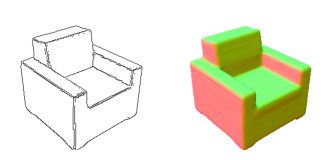

siamese_loss(sketch_5_emb, rendered_normal_3_emb)=tensor([0.9412], device='cuda:0')


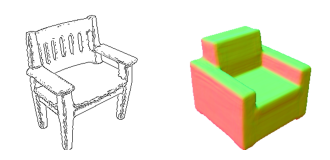

In [48]:
cfg = load_config("optimize_sketch", ["+data=shapenet_chair_4096"])
metainfo = MetaInfo(cfg.data.data_dir)

cfg.siamese_ckpt_path = siamese_ckpt_path
cfg.model.shape_k = shape_k
cfg.model.shape_view_id = shape_view_id
cfg.model.shape_init = True
cfg.model.obj_id = metainfo.obj_ids[3]
model = hydra.utils.instantiate(cfg.model).to("cuda")

sketch_3 = np.asarray(metainfo.load_image(3, 11, 0))
sketch_5 = np.asarray(metainfo.load_image(5, 11, 0))
model.latent = model.deepsdf.lat_vecs.weight[3]
rendered_normal_3 = model.capture_camera_frame().detach().cpu().numpy()

rendered_normal_3_emb = model.siamese(transform(rendered_normal_3)[None, ...])
sketch_3_emb = model.siamese(transform(sketch_3)[None, ...])
sketch_5_emb = model.siamese(transform(sketch_5)[None, ...])

print(f"{siamese_loss(sketch_3_emb, rendered_normal_3_emb)=}")
plot_images([sketch_3, rendered_normal_3])

print(f"{siamese_loss(sketch_5_emb, rendered_normal_3_emb)=}")
plot_images([sketch_5, rendered_normal_3])

6/6: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


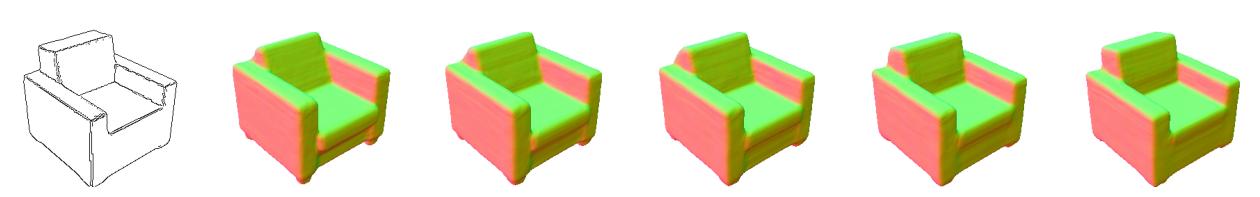

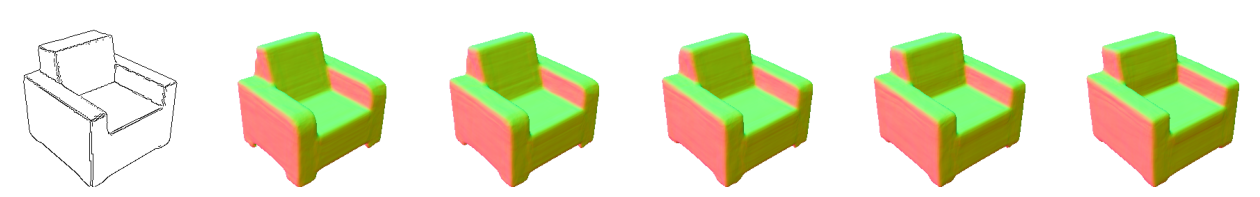

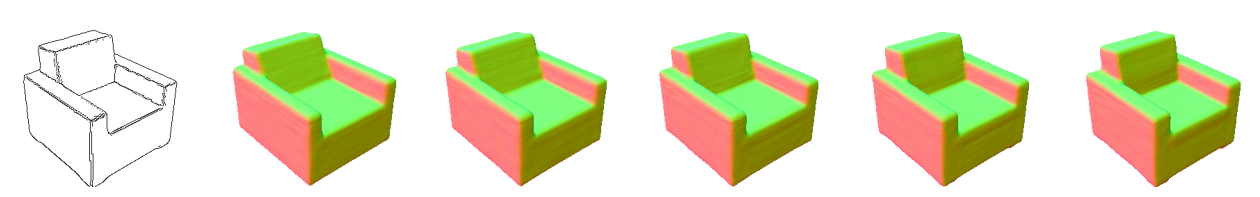

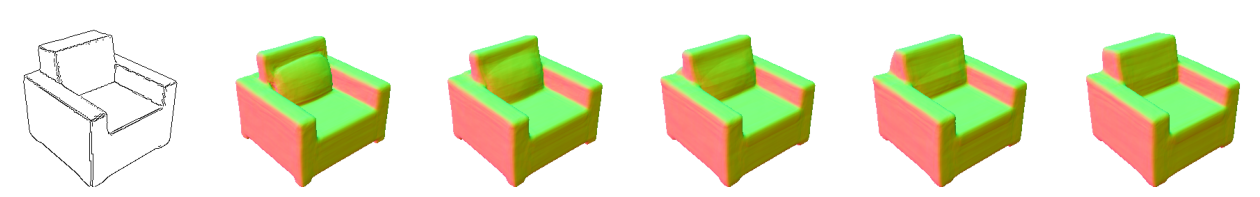

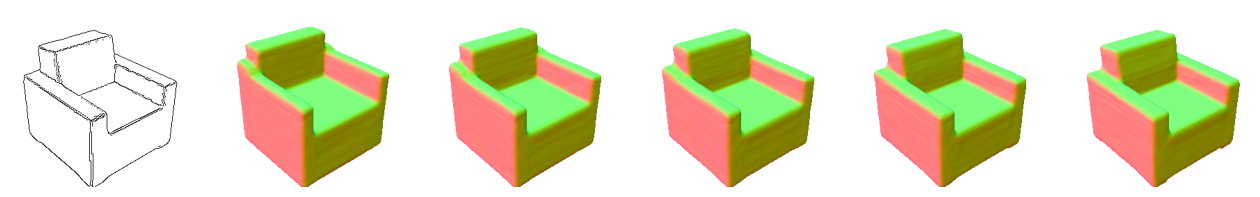

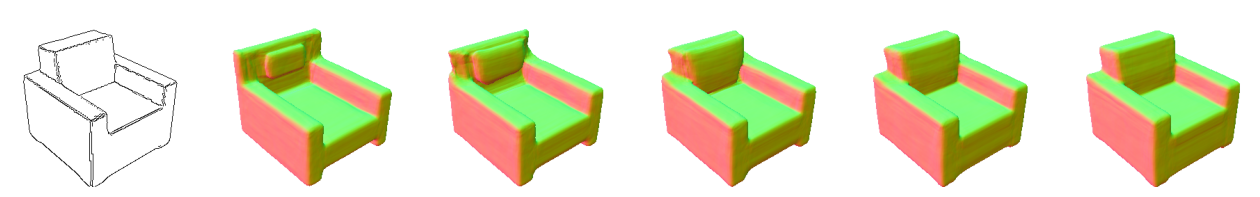

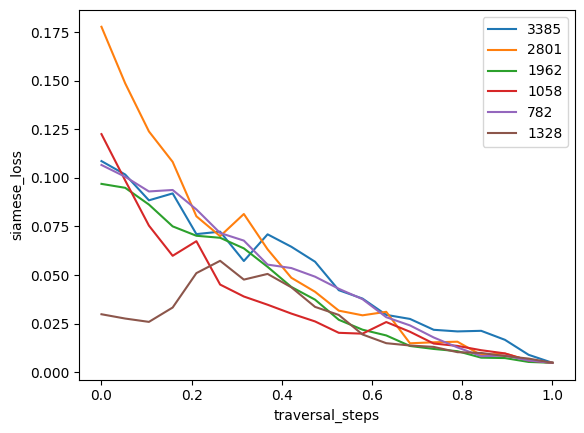

Text(0.5, 0, 'traversal_steps')

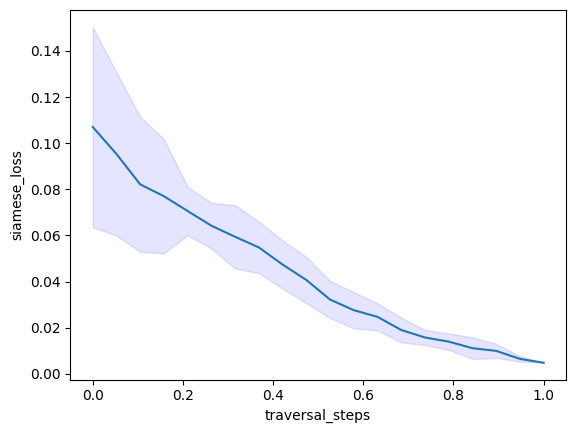

In [57]:
# settings
start_latent_ids = [3385, 2801, 1962, 1058, 782, 1328]  # couch nn
# start_latent_ids = [3, 0, 1, 2, 4, 5, 6] # couch far
# start_latent_ids = [3, 0, 1, 2, 4, 5, 6] # couch far
# start_latent_ids = [0, 5]  # couch far
end_latent_id = 3
sketch_view = 11
traversal_steps = 20
image_skip = 4
azims = [40]
elevs = [-30]

# fetch and encode the sketch
sketch = metainfo.load_image(end_latent_id, sketch_view, 0)
sketch_emb = model.siamese(transform(sketch)[None, ...])

image_trajectories = []
loss_trajectories = []
for idx, start_latent_id in enumerate(start_latent_ids):
    image_trajectory = [sketch]
    loss_trajectory = []
    desc = f"{idx+1}/{len(start_latent_ids)}"
    for t in tqdm(np.linspace(1, 0, traversal_steps), desc=desc):
        start_latent = model.deepsdf.lat_vecs.weight[start_latent_id]
        end_latent = model.deepsdf.lat_vecs.weight[end_latent_id]
        model.latent = t * start_latent + (1 - t) * end_latent

        # calculate the mean loss from all the views
        loss = []
        for azim in azims:
            for elev in elevs:
                model.deepsdf.create_camera(azim=azim, elev=elev)
                rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
                rendered_normal_emb = model.siamese(
                    transform(rendered_normal)[None, ...]
                )
                snn_loss = siamese_loss(sketch_emb, rendered_normal_emb)
                loss.append(snn_loss)
                image_trajectory.append(rendered_normal)
        loss = torch.stack(loss).mean()

        # add the loss to the trajectory
        loss_trajectory.append(loss.detach().cpu().numpy())
    loss_trajectories.append(loss_trajectory)
    image_trajectories.append(image_trajectory)

# plot the images
for image_trajectory in image_trajectories:
    trajectory = []
    for idx, img in enumerate(image_trajectory):
        if idx == 0 or (idx - 1) % image_skip == 0:
            trajectory.append(img)
    plot_images(trajectory, size=16)

# plot the loss curves
for obj_id, loss_trajectory in zip(start_latent_ids, loss_trajectories):
    plt.plot(
        np.linspace(0, 1, traversal_steps),
        np.stack(loss_trajectory),
        label=obj_id,
    )
    plt.legend(loc="upper right")
plt.ylabel("siamese_loss")
plt.xlabel("traversal_steps")
plt.show()

x = np.linspace(0, 1, 20)
mean = np.stack(loss_trajectories).mean(0)
std = np.stack(loss_trajectories).std(0)
plt.plot(x, mean)
plt.fill_between(x, (mean - std), (mean + std), color="b", alpha=0.1)
plt.ylabel("siamese_loss")
plt.xlabel("traversal_steps")

# Optimize Latent Code (Simple)

In [64]:
model.shape_idx

tensor([2548, 1327, 1897,  961,  534,  754, 2431, 3088, 3884, 1446, 3194, 2206,
         276, 1057,  840, 1636], device='cuda:0')

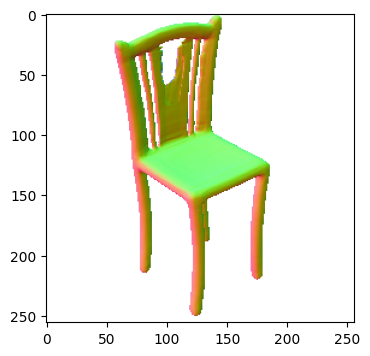

In [67]:
std = model.shape_latents.std(0)
model.latent = model.shape_latents.mean(0)
model.latent = model.deepsdf.lat_vecs.weight[1057]
normal = model.capture_camera_frame()
plot_images(normal.detach().cpu().numpy())

# reg_loss = ((model.latent.clone() - mean) / std).pow(2)
# reg_loss.mean()

100%|██████████| 10/10 [00:05<00:00,  1.75it/s, t=1]


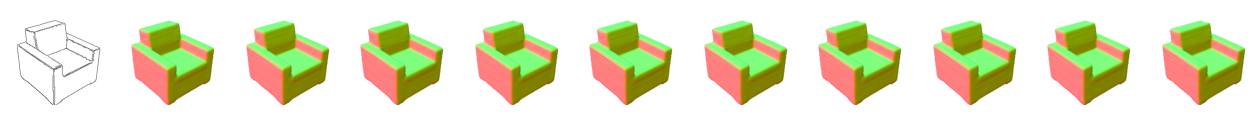

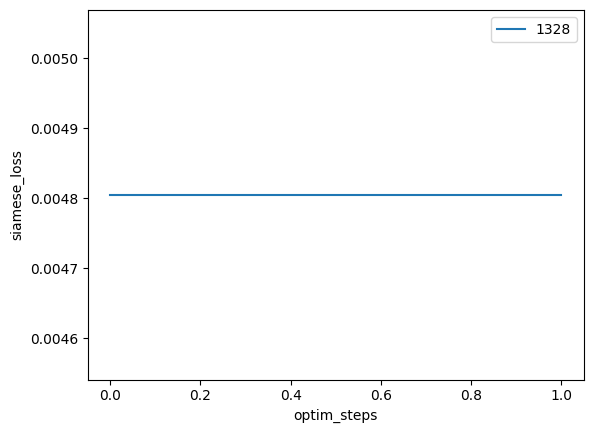

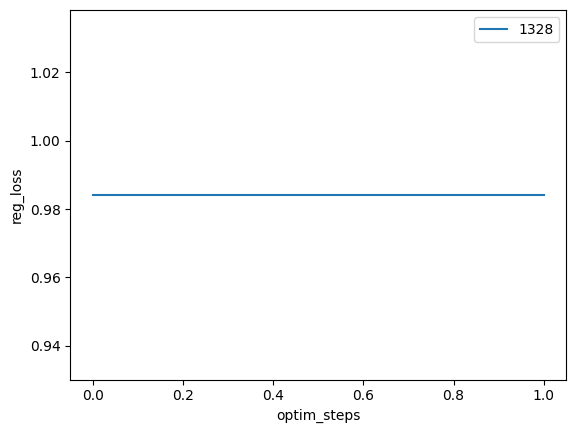

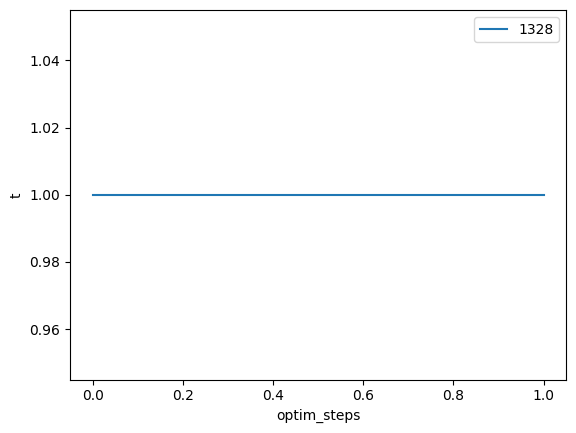

In [59]:
start_latent_id = 3
end_latent_id = 3
optim_steps = 10

t = torch.tensor(1.0, dtype=torch.float32).to("cuda")
t.requires_grad = True
start_latent = model.deepsdf.lat_vecs.weight[start_latent_id]
start_latent.requires_grad = True
end_latent = model.deepsdf.lat_vecs.weight[end_latent_id]
end_latent.requires_grad = True

optimizer = torch.optim.Adam([t], lr=0.1)

sketch = metainfo.load_image(end_latent_id, 11, 0)
sketch_emb = model.siamese(transform(sketch)[None, ...])

image_trajectory = [np.asarray(sketch)]
loss_trajectory = []
reg_loss_trajectory = []
t_trajectory = []
with tqdm(total=optim_steps) as pbar:
    for step in range(optim_steps):
        model.latent = t * start_latent + (1 - t) * end_latent
        points, surface_mask = model.deepsdf.sphere_tracing(
            latent=model.latent,
            points=model.deepsdf.camera_points,
            rays=model.deepsdf.camera_rays,
            mask=model.deepsdf.camera_mask,
        )
        rendered_normal = model.deepsdf.render_normals(
            latent=model.latent,
            points=points,
            mask=surface_mask,
        )  # (H, W, 3)
        normal = model.deepsdf.normal_to_siamese(rendered_normal)  # (1, 3, H, W)
        normal_emb = model.siamese(normal)  # (1, D)

        snn_loss = siamese_loss(sketch_emb, normal_emb)

        std = model.shape_latents.std(0)
        mean = model.shape_latents.mean(0)
        reg_loss = ((model.latent.clone() - mean) / std).pow(2)
        reg_loss_trajectory.append(reg_loss.mean().item())

        loss_trajectory.append(snn_loss.item())        
        t_trajectory.append(t.item())        
        image_trajectory.append(rendered_normal.detach().cpu().numpy())

        snn_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pbar.set_postfix({"t": t.item()})
        pbar.update(1)

# images
plot_images(image_trajectory, size=16)

# loss
plt.plot(
    np.linspace(0, 1, optim_steps),
    np.stack(loss_trajectory),
    label=obj_id,
)
plt.legend(loc="upper right")
plt.ylabel("siamese_loss")
plt.xlabel("optim_steps")
plt.show()

plt.plot(
    np.linspace(0, 1, optim_steps),
    np.stack(reg_loss_trajectory),
    label=obj_id,
)
plt.legend(loc="upper right")
plt.ylabel("reg_loss")
plt.xlabel("optim_steps")
plt.show()

plt.plot(
    np.linspace(0, 1, optim_steps),
    np.stack(t_trajectory),
    label=obj_id,
)
plt.legend(loc="upper right")
plt.ylabel("t")
plt.xlabel("optim_steps")
plt.show()